
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [162]:
import zipfile
import os
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import matplotlib.gridspec as gridspec
import numpy as np
import statsmodels.api as sm
%matplotlib inline

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [2]:
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  3149k      0 --:--:--  0:00:01 --:--:-- 3151k


In [3]:
!mv energy.csv $PUIDATA

In [4]:
!curl https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip > buildingunit.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  31.5M      0 --:--:-- --:--:-- --:--:-- 31.5M


In [5]:
!mv buildingunit.zip $PUIDATA

In [6]:
buildingunit = zipfile.ZipFile(os.getenv('PUIDATA') + '/buildingunit.zip')
buildingunit.extractall(os.getenv('PUIDATA'))

In [7]:
energy = pd.read_csv(os.getenv('PUIDATA') + '/energy.csv')
buildingunit = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/MNMapPLUTO.shp')

In [8]:
energy.head(3)
#BBL: NYC Borough, Block, and Lot

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
buildingunit.head(3)

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."


## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

In [10]:
energy.shape

(16170, 32)

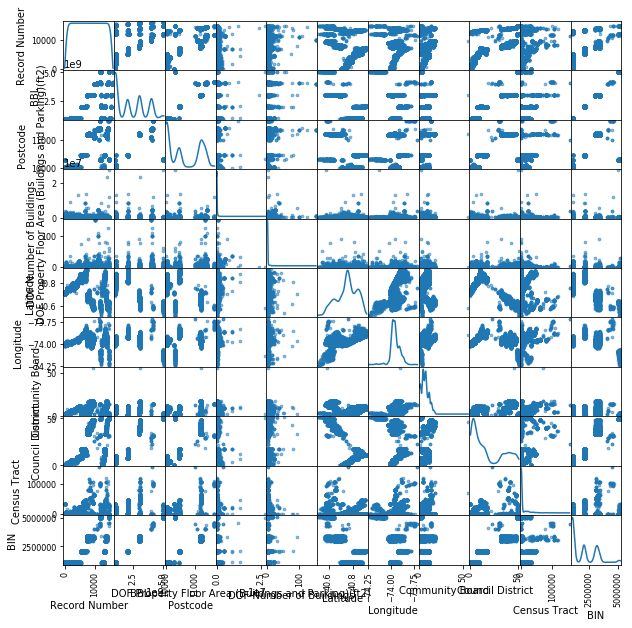

In [11]:
matrix = pd.scatter_matrix(energy, s=30, figsize=(10,10), diagonal='kde')

**Figure 1: **The scatter matrix plot of data on energy consumption for New York city. There are some correlations shown in the graph. Throught the shape of dataframe, it contains 32 variables, however the above scatter matrix just shows the correlation between 11 variables. The reason may that some columns are not the numbers style that cannot be plotted.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u**'Site EUI(kBtu/ft2)'** which is a measure of the **energy consumed PER SQ FOOT** by a building, and then the **building area**: for eg. u**'Reported Property Floor Area (Building(s)) (ft²)'**. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [12]:
energy.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [13]:
energy_sub = energy[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
energy_sub.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [14]:
buildingunit.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [15]:
BU_sub = buildingunit[['BBL' , 'UnitsTotal', 'UnitsRes', 'YearBuilt', 'geometry']]
BU_sub.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.015450e+09,18,16,1920,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,1.016800e+09,10,10,1910,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,1.011970e+09,26,26,1900,"POLYGON ((992273.6849975586 224863.4904174805,..."


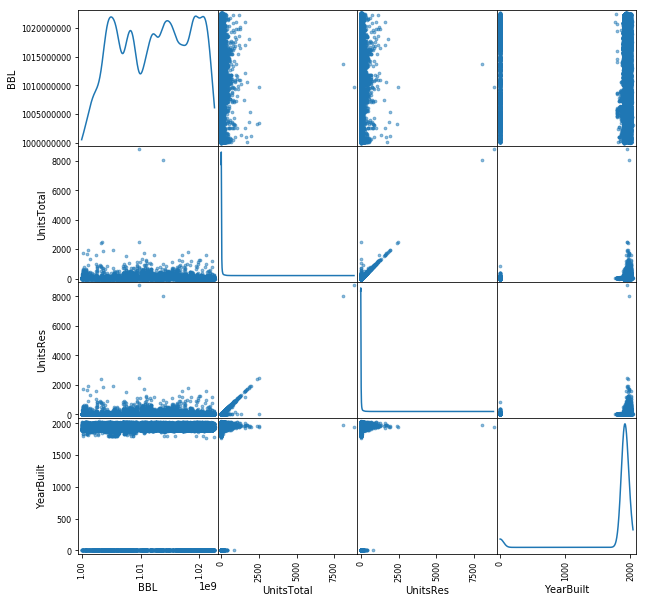

In [16]:
matrix = pd.scatter_matrix(BU_sub, s=30, figsize=(10,10), diagonal='kde')

**Figure 2:** The scatter matrix plotting after choosing data from original building unit data. The units total ans UnitsRes seems have positive correlation, while other features have not shown obvious relationship. In addition, since all variables can be plotted out, it indicates that the data type is numeric.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [17]:
energy_sub.columns

Index(['BBL', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')

In [18]:
energy_sub['Site EUI(kBtu/ft2)'] = pd.to_numeric(energy_sub['Site EUI(kBtu/ft2)'], errors='coerce')
energy_sub['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(energy_sub['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
##check that your conversion worked: e.g.
energy_sub['Site EUI(kBtu/ft2)'].astype(float), BU_sub.BBL.astype(float)
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


(0          NaN
 1          NaN
 2          NaN
 3          NaN
 4          NaN
 5          NaN
 6          NaN
 7          NaN
 8          NaN
 9          NaN
 10         NaN
 11         NaN
 12         NaN
 13         NaN
 14         NaN
 15         NaN
 16       125.4
 17         NaN
 18         NaN
 19         NaN
 20         NaN
 21         NaN
 22         NaN
 23         NaN
 24         NaN
 25         NaN
 26         NaN
 27         NaN
 28         NaN
 29         NaN
          ...  
 16140      NaN
 16141      NaN
 16142      NaN
 16143      NaN
 16144      NaN
 16145      NaN
 16146      NaN
 16147      NaN
 16148      NaN
 16149      NaN
 16150      NaN
 16151      NaN
 16152      NaN
 16153      NaN
 16154      NaN
 16155      NaN
 16156      NaN
 16157      NaN
 16158      NaN
 16159      NaN
 16160      NaN
 16161      NaN
 16162      NaN
 16163      NaN
 16164      NaN
 16165      NaN
 16166      NaN
 16167      NaN
 16168      NaN
 16169      NaN
 Name: Site EUI(kBtu/ft2

In [20]:
print ('number of missing energy observations:', np.isnan(energy_sub['Site EUI(kBtu/ft2)']).sum())

number of missing energy observations: 4623


In [21]:
print ('fraction of missing energy observations:%.2f'
       %(np.isnan(energy_sub['Site EUI(kBtu/ft2)']).sum()/len(energy_sub['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations:0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [22]:
EneBuMerg = pd.merge(BU_sub, energy_sub, on='BBL')
EneBuMerg = EneBuMerg.dropna()
EneBuMerg.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,1.021740e+09,72,72,1923,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,1.008830e+09,108,107,1931,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,1.008570e+09,138,134,1910,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [23]:
EneBuMergGDF = gp.GeoDataFrame(EneBuMerg)

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [24]:
EneBuMergGDF ['logunit'] = EneBuMergGDF ['UnitsTotal'].apply(lambda x: np.log10(x+1)).astype(float)
EneBuMergGDF ['logenergy'] = EneBuMergGDF ['Site EUI(kBtu/ft2)'].apply(lambda x: np.log10(x+1)).astype(float)

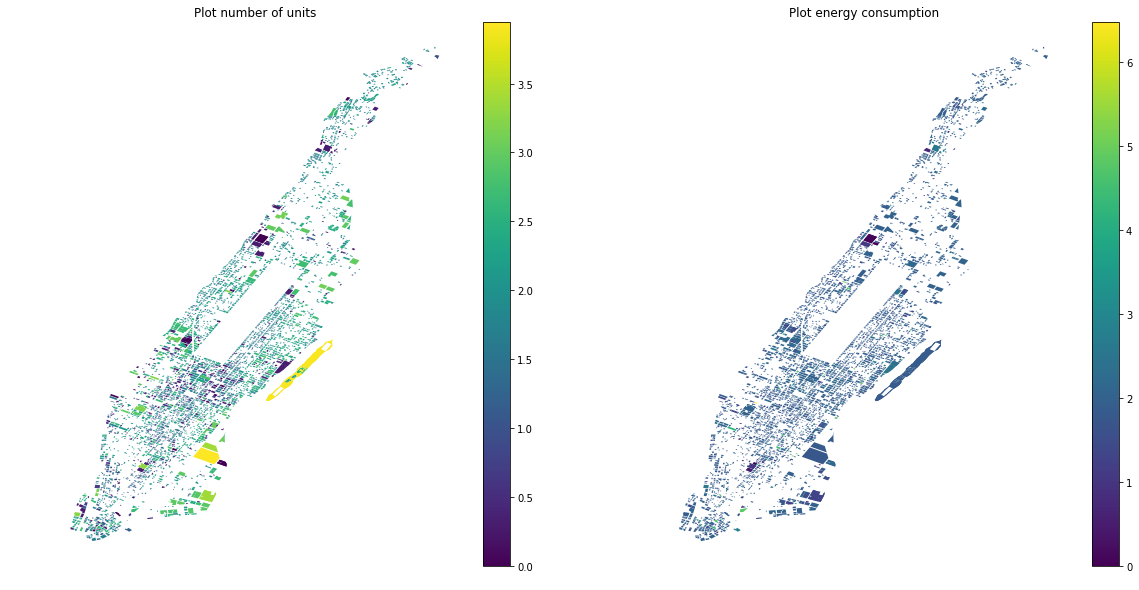

In [25]:
#plot 'UnitsTotal' and 'Site EUI(kBtu/ft2)' under log base
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.axis('off')
ax1.set_title('Plot number of units')
EneBuMergGDF.plot(column='logunit', cmap='viridis', legend=True, ax=ax1) 

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('Plot energy consumption')
EneBuMergGDF.plot(column='logenergy', cmap='viridis', legend=True, ax=ax2)

**Figure 3:** These two graph plot number of units and energy energy under the log10 base as a choropleth in the GeoPandas. To aviod the infinite number from log10(0), all data is calculated by log10(x+1). to Overall, the building units keeps at the high level while the energy used keeps at the lower level. Since the lighter areas in units graph tend to correspond with energy graph, it indicates that the greater number of units, the less energy consumption (kBtu/ft). 

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [26]:
EneBuMerg['totalenergy'] = EneBuMerg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                    EneBuMerg['Site EUI(kBtu/ft2)'].astype(float)
print('minimum building energy value: ', min(EneBuMerg['totalenergy']))
print('maximum building energy value: ', max(EneBuMerg['totalenergy']))

minimum building energy value:  0.0
maximum building energy value:  350145188000.0


Text(0,0.5,'Number of units in building')

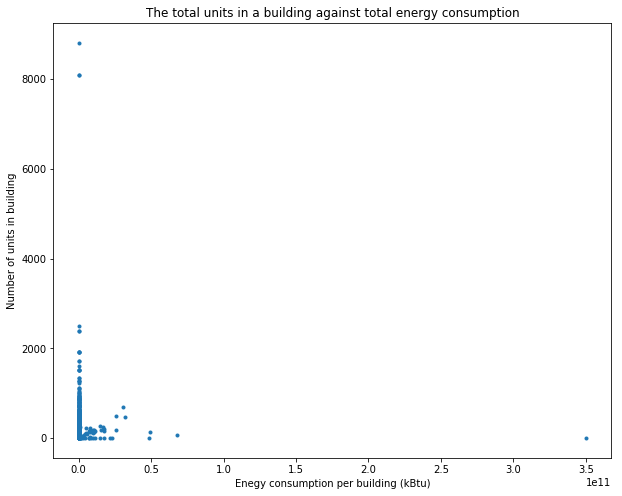

In [27]:
#plot all points 
fig = plt.figure(figsize=(10,8))
plt.plot(EneBuMerg['totalenergy'], EneBuMerg['UnitsTotal'], '.')
plt.title('The total units in a building against total energy consumption')
plt.xlabel('Enegy consumption per building (kBtu)')
plt.ylabel('Number of units in building')

**Figure 3**: This figure plots the total units in a building against total energy consumption. It is obvious that most points are gathered at the left bottom corner. This is because there have several outliers, which deminish the visualization quality.

(0, 1000)

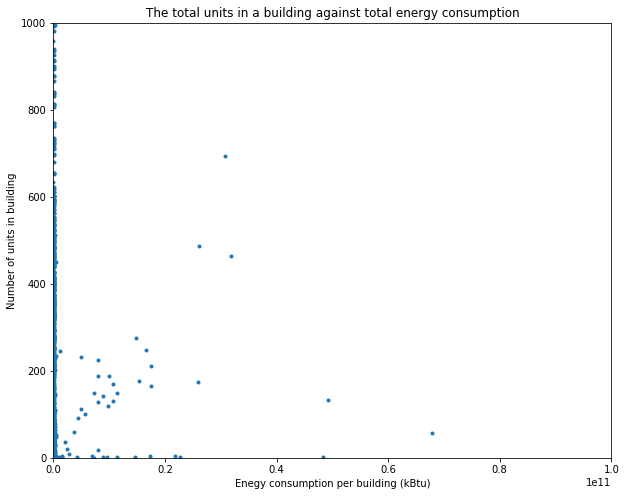

In [28]:
#plots without outliers
fig = plt.figure(figsize=(10,8))
plt.plot(EneBuMerg['totalenergy'], EneBuMerg['UnitsTotal'], '.')
plt.title('The total units in a building against total energy consumption')
plt.xlabel('Enegy consumption per building (kBtu)')
plt.ylabel('Number of units in building')
plt.xlim(0,1e11)
plt.ylim(0,1000)

**Figure 4:** This figure plots the total units in a building against total energy consumption after removing some outliers. Except some 0 energy consumption, it seems that the number of units in building has the positive correlation with the energy consumption per building. 

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

**In log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5**(basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

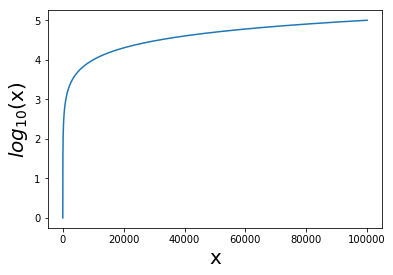

In [29]:
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a **power law (y = x^a)** then the relationship between the log of the variables is **linear!** And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


(1000, 100000000000.0)

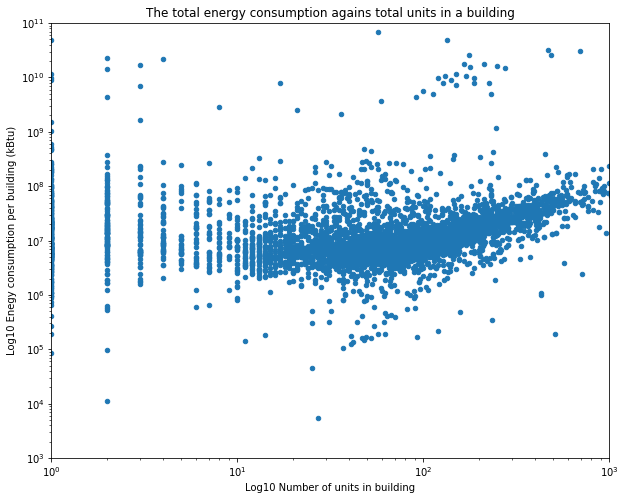

In [30]:
#plot energy Vs units under log:
EneBuMerg = pd.DataFrame(EneBuMerg)
fig = plt.figure(figsize=(15,8))
EneBuMerg.plot(x='UnitsTotal', y='totalenergy', kind='scatter', loglog=True, figsize=(10,8))
plt.title('The total energy consumption agains total units in a building')
plt.xlabel('Log10 Number of units in building')
plt.ylabel('Log10 Enegy consumption per building (kBtu)')
plt.xlim(1,1000)
plt.ylim(1000,1e11)

**Figure 5**: The total energy consumption agains total units in a building, both under log10 scaler. Under 100 units, the number of units since has no relationship with the energy consumption, while after 100, with the greater number of units, the energy consumption seems increased. 

(1, 1000)

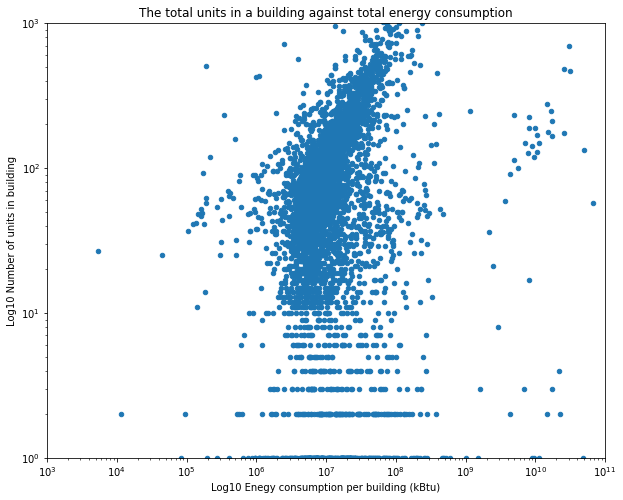

In [31]:
#plot units Vs energy under log:
fig = plt.figure(figsize=(15,8))
EneBuMerg.plot(x='totalenergy', y='UnitsTotal', kind='scatter', loglog=True, figsize=(10,8))
plt.title('The total units in a building against total energy consumption')
plt.xlabel('Log10 Enegy consumption per building (kBtu)')
plt.ylabel('Log10 Number of units in building')
plt.xlim(1000,1e11)
plt.ylim(1,1000)

**Figure 6 :** The total units in a building against total energy consumption, both under log10 scaler. The independent variable enegy consumption is spread aound 10^7. When moving from 10^7 to larger number, the number of units seems increased. 

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer** I think the units "cause" energy consumption. Because only if we have the units (which means have that building), we can have corresponding chance to consume energy. 

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

In [32]:
#tailor the dataframe to the suitable range:
EneBuMerg_cut = EneBuMerg[(EneBuMerg['totalenergy']>1000) & (EneBuMerg['totalenergy']<1e11)
                         & (EneBuMerg['UnitsTotal']>1) & (EneBuMerg['UnitsTotal']<1000)]

In [33]:
#convert to the log base
EneBuMerg_cut['logtenergy'] = np.log10(EneBuMerg_cut['totalenergy'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Units vs Energy

In [65]:
OLS_UvE = smf.ols(formula='logunit ~ logtenergy', data=EneBuMerg_cut).fit()
OLS_UvE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logunit   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     259.6
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           7.15e-57
Time:                        22:42:04   Log-Likelihood:                -3185.1
No. Observations:                4642   AIC:                             6374.
Df Residuals:                    4640   BIC:                             6387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2122      0.099      2.145      0.032         0.018     0.406
logtenergy     0.2257      0.014     16.112      0.000         0.198     0.253
==============================================================================
Omnibus:                      613.002   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              934.829
Skew:                          -0.945   Prob(JB):                    1.01e-203
Kurtosis:                       4.124   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Figure 7:** Print the model summary of log10(total units) against log10(energy consumption). The R-squared is just 0.053, which indicates a low fitness of this model. Log-Likelihood for this model is -3185.1.

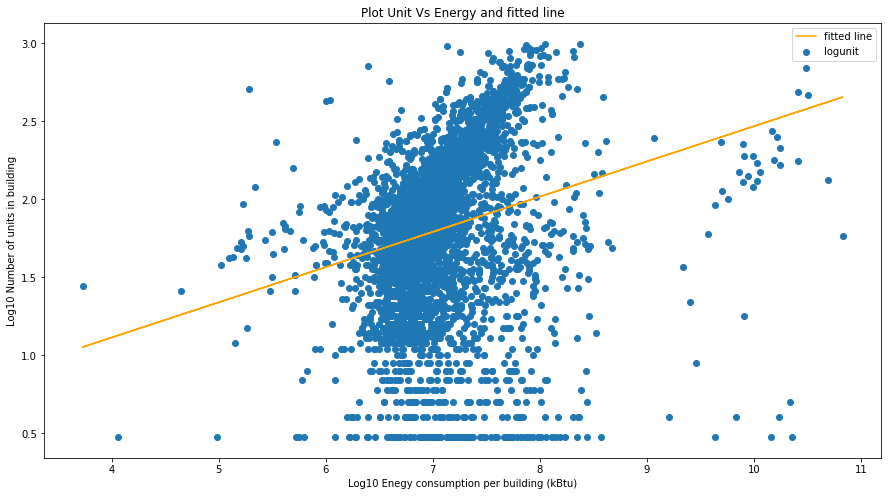

In [35]:
fig = plt.figure(figsize=(15,8))
plt.scatter(EneBuMerg_cut['logtenergy'], EneBuMerg_cut['logunit'])
plt.plot(EneBuMerg_cut['logtenergy'], OLS_UvE.predict(EneBuMerg_cut), '-', color='orange', label='fitted line')
plt.title('Plot Unit Vs Energy and fitted line')
plt.xlabel('Log10 Enegy consumption per building (kBtu)')
plt.ylabel('Log10 Number of units in building')
plt.legend()

**Figure 8:** Fit the line to the Unit against Energy model by applying ols. It seems that the line is hard to fit all data well.

### Energy against Units

In [36]:
OLS_EvU = smf.ols(formula='logtenergy ~ logunit', data=EneBuMerg_cut).fit()
OLS_EvU.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logtenergy   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     259.6
Date:                Sat, 24 Nov 2018   Prob (F-statistic):           7.15e-57
Time:                        21:35:26   Log-Likelihood:                -3276.4
No. Observations:                4642   AIC:                             6557.
Df Residuals:                    4640   BIC:                             6570.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.6234      0.027    243.221      0.000         6.570     6.677
logunit        0.2348      0.015     16.112      0.000         0.206     0.263
==============================================================================
Omnibus:                     2200.473   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31078.599
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      15.095   Cond. No.                         8.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Figure 7:** Print the model summary of log10(energy consumption) against log10(total units). The R-squared is just 0.053, which indicates a low fitness of this model. Log-Likelihood for this model is -3276.4.

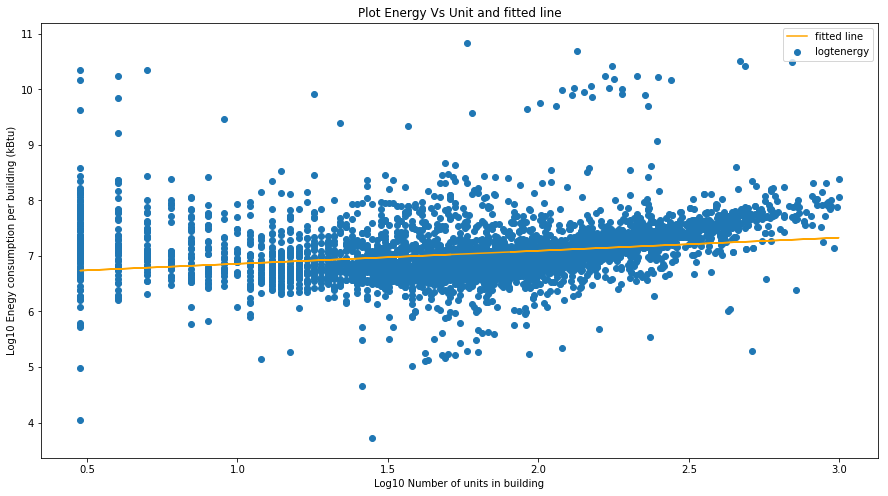

In [37]:
fig = plt.figure(figsize=(15,8))
plt.scatter(EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'])
plt.plot(EneBuMerg_cut['logunit'], OLS_EvU.predict(), '-', color='orange', label='fitted line')
plt.title('Plot Energy Vs Unit and fitted line')
plt.xlabel('Log10 Number of units in building')
plt.ylabel('Log10 Enegy consumption per building (kBtu)')
plt.legend()

**Figure 8:** Fit the line to the Unit against Energy model by applying ols. It seems that the line across the data, better than Figure 6 shown.

### Comparison:

Both Units Vs Energy and Energy Vs Units have the same R-sqaured, however, the second model has higher log-likelihood. Log-likelihood can be used to compare the fit of different coefficients. Because we want to maximize the log-likelihood, the higher value is better, so the second model is better compared to the first one. 

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [38]:
#EneBuMerg_cut['Logunit2'] = 2 * EneBuMerg_cut['Logunit']

In [39]:
OLS_EvU2 = smf.ols(formula='logtenergy ~ I(logunit**2) + logunit', data=EneBuMerg_cut).fit()
OLS_EvU2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logtenergy   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     545.8
Date:                Sat, 24 Nov 2018   Prob (F-statistic):          1.36e-213
Time:                        21:35:26   Log-Likelihood:                -2912.3
No. Observations:                4642   AIC:                             5831.
Df Residuals:                    4639   BIC:                             5850.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           7.9407      0.053    149.101      0.000         7.836     8.045
I(logunit ** 2)     0.5250      0.019     28.070      0.000         0.488     0.562
logunit            -1.5134      0.064    -23.751      0.000        -1.638    -1.388
==============================================================================
Omnibus:                     2296.639   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45163.004
Skew:                           1.898   Prob(JB):                         0.00
Kurtosis:                      17.801   Cond. No.                         55.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Figure 9:** Print the model summary of Second degree polynomial model: log10(energy consumption) against log10(total units) and the saqure of log10(total units). The R-squared is increased to 0.190, which the fitness of this model is increased. 

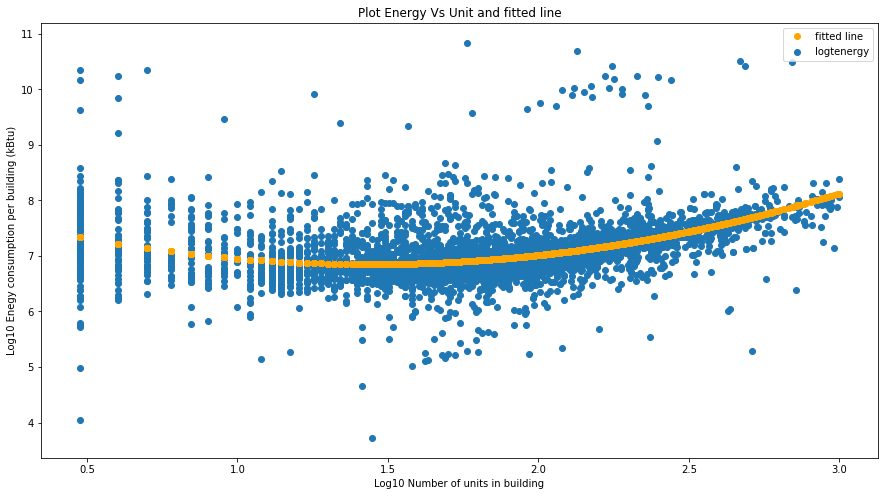

In [166]:
fig = plt.figure(figsize=(15,8))
plt.scatter(EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'])
#abline_plot(model_results=OLS_EvU2)
plt.plot(EneBuMerg_cut['logunit'], OLS_EvU2.predict(), 'o', color='orange', label='fitted line')
plt.title('Plot Energy Vs Unit and fitted line')
plt.xlabel('Log10 Number of units in building')
plt.ylabel('Log10 Enegy consumption per building (kBtu)')
plt.legend()

**Figure 10**: Plot the fitted line of second degree polynomial model. The line seems fit the model better.

# calculate the chi square and likelihood of your model

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [168]:
EneBuMerg_cut['errorteng'] = np.sqrt(EneBuMerg_cut['Reported Property Floor Area (Building(s)) (ft²)']**2 +\
                                          EneBuMerg_cut['Site EUI(kBtu/ft2)']**2)
EneBuMerg_cut['errorunit'] = np.sqrt(EneBuMerg_cut['UnitsTotal'])
EneBuMerg_cut['error_logteng'] = EneBuMerg_cut['errorteng']/(EneBuMerg_cut['totalenergy']*np.log(10))
EneBuMerg_cut['error_logunit'] = EneBuMerg_cut['errorunit'] /(EneBuMerg_cut['UnitsTotal']*np.log(10))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to 

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error is:


,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logunit,logenergy,totalenergy,logtenergy,erroreng,errorunit,error_logeng,erroreng_logunit,error_logunit,errorteng,error_logteng
3313,1.019900e+09,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",0.1,53440.0,1.447158,0.041393,5344.0,3.727866,53440.0,5.196152,4.342945,0.08358,0.08358,53440.0,4.342945


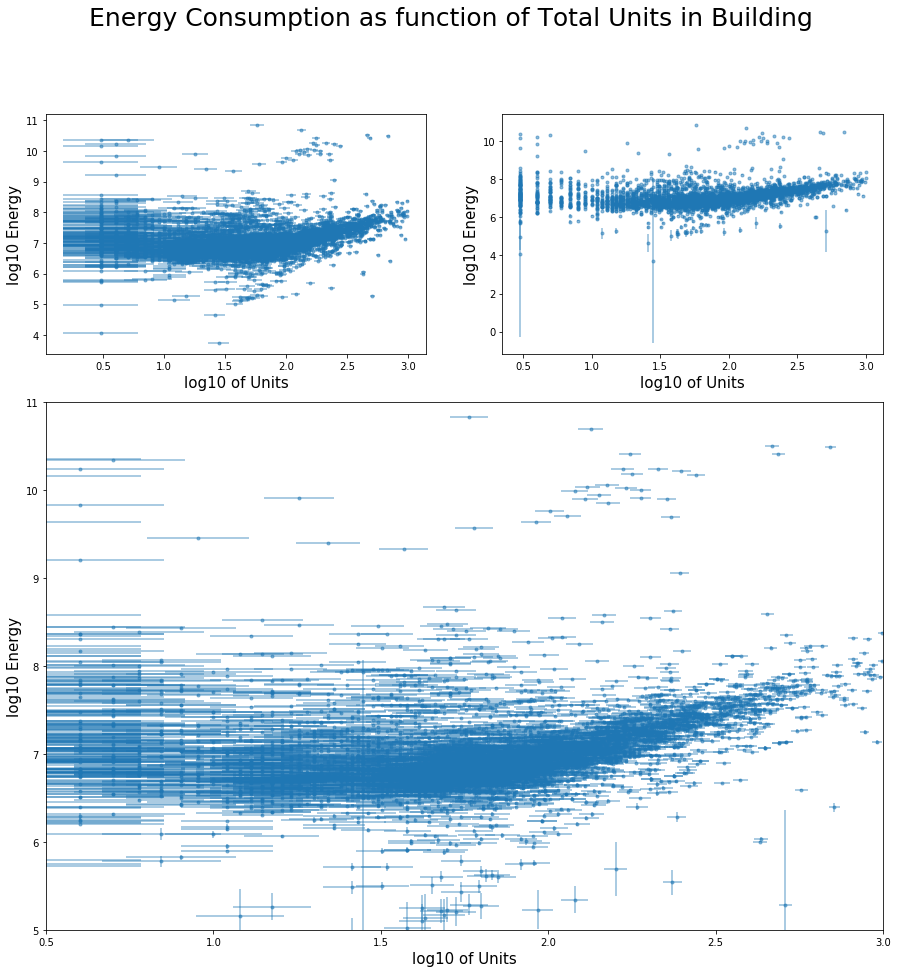

In [169]:
plt.figure(figsize=(15,15))
plt.title('Total units in building Vs Energy')
gs = gridspec.GridSpec(3, 2)
#fig.update(left=0.68, right=0.68, wspace=0.2)

#plot only with x error (error for unit):
ax1 = plt.subplot(gs[0,0])
ax1.errorbar(EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'], 
            xerr=EneBuMerg_cut['error_logunit'], fmt='.',
            alpha=0.5)
ax1.set_ylabel('log10 Energy', fontsize=15)
ax1.set_xlabel('log10 of Units', fontsize=15)
plt.suptitle('Energy Consumption as function of Total Units in Building', fontsize=25)

#plot only with y error (error for energy):
ax2 = plt.subplot(gs[0,1])
ax2.errorbar(EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'], 
            yerr=EneBuMerg_cut['error_logteng'], fmt='.',
            alpha=0.5)
ax2.set_ylabel('log10 Energy', fontsize=15)
ax2.set_xlabel('log10 of Units', fontsize=15)

#plot only with x and y error (error for unit & energy):
ax3 = plt.subplot(gs[1:,0:])
ax3.errorbar(EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'], 
            xerr=EneBuMerg_cut['error_logunit'], 
            yerr=EneBuMerg_cut['error_logteng'], fmt='.',
            alpha=0.5)
ax3.set_ylim(5,11)
ax3.set_xlim(0.5,3)
ax3.set_ylabel('log10 Energy', fontsize=15)
ax3.set_xlabel('log10 of Units', fontsize=15)

print('The largest error is:')
EneBuMerg_cut[EneBuMerg_cut['error_logteng']==EneBuMerg_cut['error_logteng'].max()]

**Figure 11:** The Energy Consumption as function of Total Units in Building plotted with the errorbars.  Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. The top left graph plots the errors on untis (x-error), top right graph plots the errors on energy (y-error), and the bottom graph plots both units and energy errors. Compared with error on units, error on energy is too small to see. 

The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [136]:
EneBuMerg_cut.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logunit,logenergy,totalenergy,logtenergy,erroreng,errorunit,error_logeng,erroreng_logunit,error_logunit
0,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,1.707570,1.843233,6584482.8,6.818522,95844.024622,7.071068,0.006322,0.061419,0.061419
1,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,1.518514,1.946452,18090838.6,7.257459,206989.018452,5.656854,0.004969,0.076773,0.076773
2,1.021740e+09,72,72,1923,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,1.863323,2.150449,7429968.0,6.870987,52920.186245,8.485281,0.003093,0.051182,0.051182
3,1.008830e+09,108,107,1931,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,2.037426,1.989005,9491643.5,6.977341,98359.047338,10.392305,0.004500,0.041790,0.041790
4,1.008570e+09,138,134,1910,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,2.143015,1.572872,5605600.0,6.748622,154000.004302,11.747340,0.011931,0.036970,0.036970


## Define a chisquare function

In [125]:
#leave
def chi2(data, model, errors=1):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    return float(np.sum(((model.predict() - data)**2/(errors)**2)))
    

In [104]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = EneBuMerg_cut.shape[0]-1
print ("degrees of freedom:" , dof)

degrees of freedom: 4641


In [171]:
print('Units vs Energy residuals (no errors include): %.2f'\
      %(chi2(EneBuMerg_cut['logunit'], OLS_UvE)/dof))

print("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       ((chi2(EneBuMerg_cut['logunit'], OLS_UvE, errors = EneBuMerg_cut['error_logteng']))/dof)

print("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(EneBuMerg_cut['logunit'], OLS_UvE,
             errors = np.sqrt(EneBuMerg_cut['error_logteng']**2+
                              EneBuMerg_cut['error_logunit']**2))/ dof))



SyntaxError: invalid syntax (<ipython-input-171-4801e94b5a8c>, line 5)

In [172]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(EneBuMerg_cut['logunit'], OLS_UvE) / float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(EneBuMerg_cut['logunit'], OLS_UvE, 
            errors = EneBuMerg_cut['error_logteng']) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(EneBuMerg_cut['logunit'], OLS_UvE, 
            errors = np.sqrt(EneBuMerg_cut['error_logteng']**2 + 
                             EneBuMerg_cut['error_logunit']**2))  / dof))


Units vs Energy residuals (no errors include): 0.23
Units vs Energy chi square per DOF w independent variable error only: 118170341.38
Units vs Energy chi square per DOF : 140.05


In [173]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(EneBuMerg_cut['logtenergy'], OLS_EvU) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(EneBuMerg_cut['logtenergy'], OLS_EvU, 
            errors = EneBuMerg_cut['error_logunit']) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(EneBuMerg_cut['logtenergy'], OLS_EvU, 
            errors = np.sqrt(EneBuMerg_cut['error_logteng']**2 + 
                             EneBuMerg_cut['error_logunit']**2))  / dof))


Energy vs Units residuals (no errors include): 0.24
Energy vs Units chi square per DOF w independent variable error only: 144.90
Energy vs Units chi square per DOF : 131.98


### Compare the models using the  chi square:
**Answer**: χ2 measures how well a model explains data including uncertainties. The χ2 /DOF (reduced χ2 or χ2 per degree of freedom of your model) is a statistics (a measurable number) that follows a χ2 distribution with mean 1. The larger the χ2 the “worse” model. Through residuals (no errors include), the "Units against Energy is slightly better, while through the chi square per DOF with independent variable error only and with both two errors, the "Energy against Units" model is better than the "Units against Energy" model.

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Text(0.5,1,'Influence Plot of OLS_Energy v Unit')

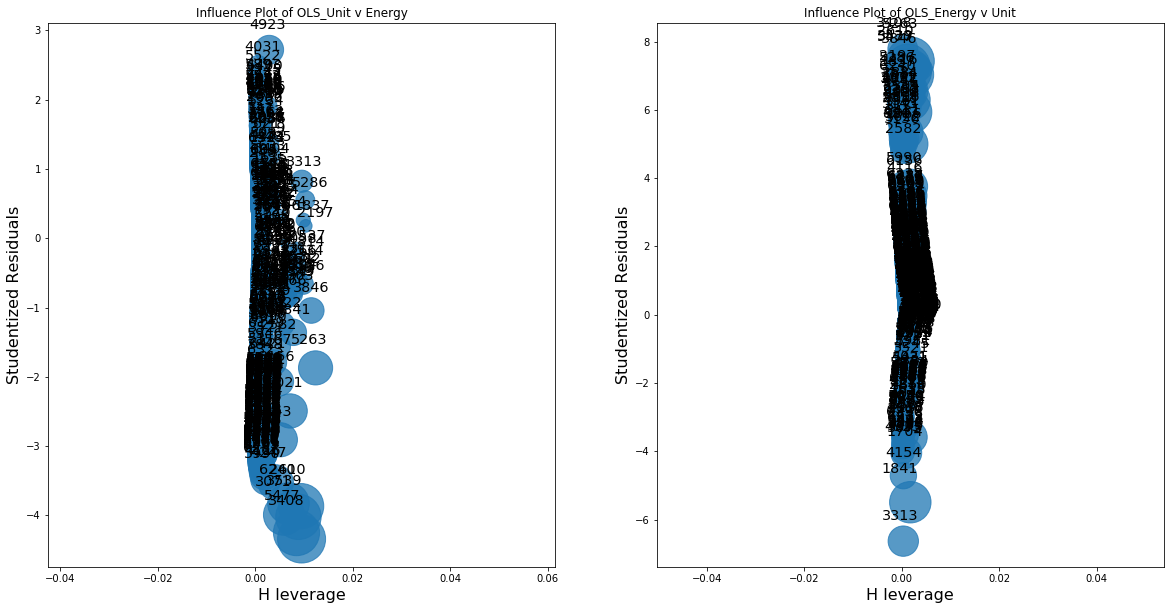

In [174]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(121)
sm.graphics.influence_plot(OLS_UvE, ax=ax1, criterion="cooks", annotation=False)
ax1.set_xlabel('H leverage')
ax1.set_ylabel('Studentized Residuals')
ax1.set_title('Influence Plot of OLS_Unit v Energy')

ax2 = fig.add_subplot(122)
sm.graphics.influence_plot(OLS_EvU, ax=ax2, criterion="cooks", annotation=False)
ax2.set_xlabel('H leverage')
ax2.set_ylabel('Studentized Residuals')
ax2.set_title('Influence Plot of OLS_Energy v Unit')

**Figure 12**: The influence plot of two ols model. The left is Unit Vs Energy model, and the right is Energy Vs Unit model. It is obviously that the left plot has more points with high leverage than the right plot.

Recall back to the previous scatter plot, in the units vs energy plot, most values of the exogenous variable (energy) are clustered in a vertical small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit.

In the Energy vs Units plot, the distribution of points along the exogenous variable is much better suited to a line fit, which means that less data points are extreme with respect to x, so there are no high leverage points. Overall, less data points would appear to be influential with respect to the location of the best fitting line



# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [147]:
OLS_EvU2.compare_lr_test(OLS_EvU)

(728.20946993642247, 2.1955347519336997e-160, 1.0)

**Summary: reject null hypothesis**

The likelihood ratio test is used to compare how well two statistical models, one with a potential confounder and one without, fit a set of observations. In this case, the null model is OLS_EvU which is nested, only containing units. The alternative model is OLS_EvU2 which contains one more variable unit^2. The null hypothesis is that compared to the null model, the alternative model don't fit the data better.

The statistic calculated from a likelihood ratio test follows a chi-square distribution with degrees of freedom equal to the difference in degrees of freedom of the two models. In this case the DOF=1. The return of above "compare_lr_test" function is likelihood ratio, p-value of the test statistic, and degrees of freedom of the restriction(deifference between 2 models). Under 0.05 significance level, the p-value approches to 0 which is far less than 0.05. In addtion, the chi-square result is also far large than 3.84. Therefore, we can reject the null hypothesis: the alternative model (which is t he polynomial model) fits the data better.

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that *maximizing the log likelihood is the same as minimizing the chi square*).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

### Note: I choose the Energy Vs Units model to do this question

In [214]:
def residuals(a,b,x,y,errors=1):
    return np.nansum((x*a+b-y)**2/(errors)**2)

In [213]:
Coef = np.arange(-100.0, 100.0, 0.5)
Interc = np.arange(-100.0, 100.0, 0.5)

In [216]:
resids_noerror = np.zeros((len(Coef),len(Interc)))
resids = np.zeros((len(Coef),len(Interc)))
for i,a in enumerate(Coef):
    for j,b in enumerate(Interc):
        resids_noerror[i][j] = residuals(a,b,EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'])
        resids[i][j] = residuals(a,b,EneBuMerg_cut['logunit'], EneBuMerg_cut['logtenergy'], 
                                 errors=EneBuMerg_cut['error_logteng'])

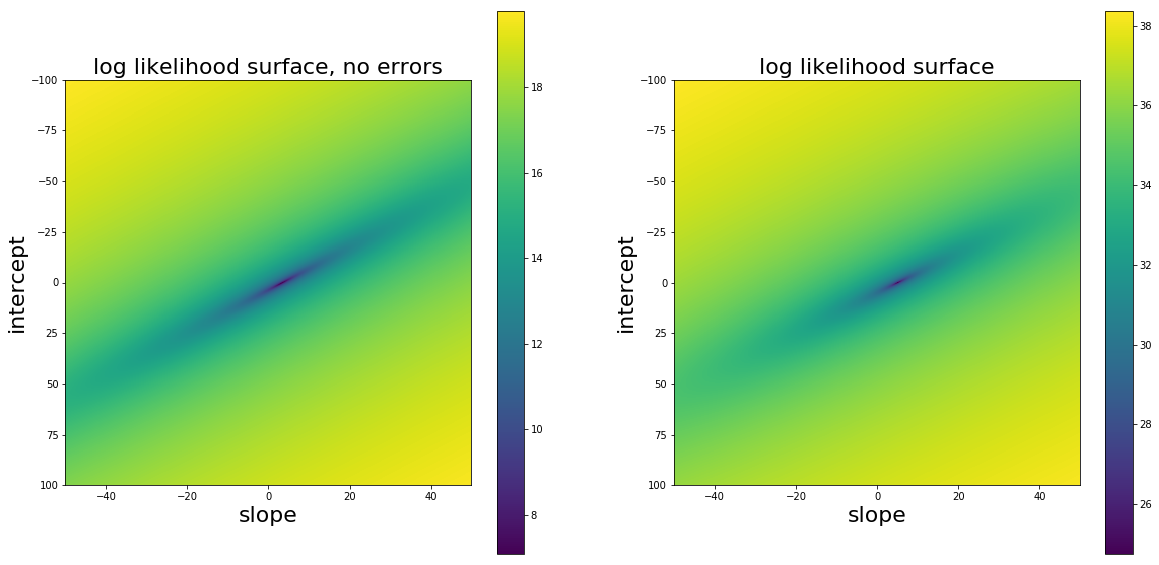

In [227]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
plt.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
plt.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
plt.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
plt.colorbar();


**Figure 13**: the likelihood surface without error and with error. Since maximizing the log likelihood is the same as minimizing the chi square, the minimum points in these two graph are aroud slope 3 intercept -2; and slope 5 intercept -2, these two points are roughly the same place.

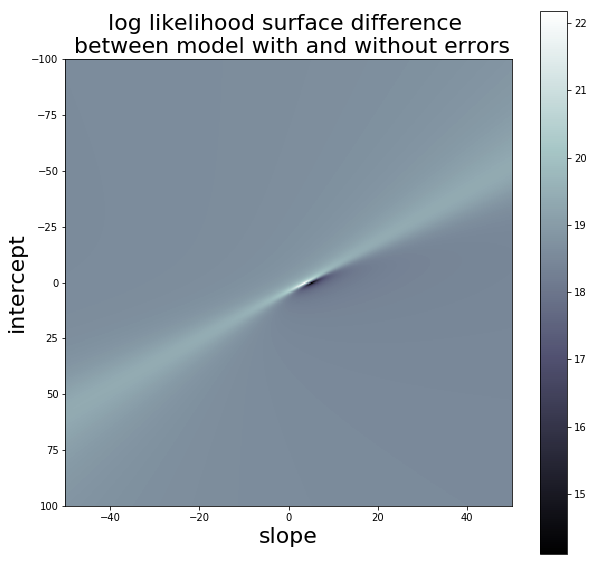

In [219]:
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = plt.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
plt.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
plt.colorbar();


**Figure 14**:the difference between the above 2 likelihood surfaces. the minimum point (darkest color) in this plot is roughly the same place as the point in above two surface. So the minimum is in the right place.

# EXTRA CREDIT: a plot of anything related to these data

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

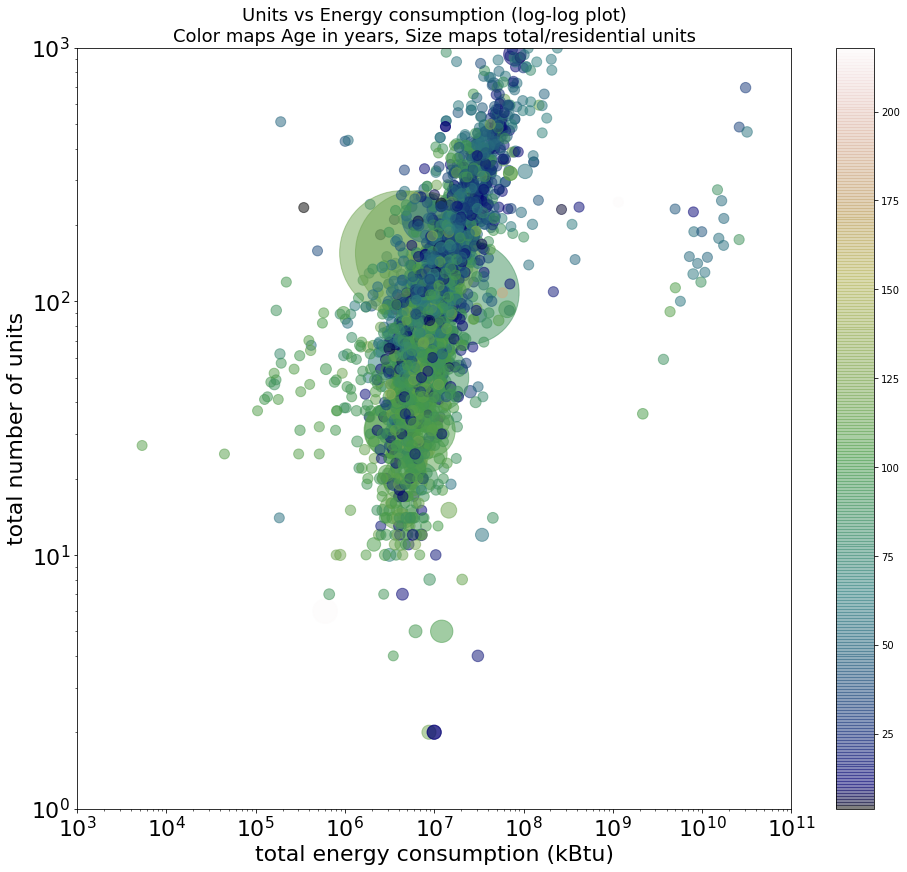

In [223]:
import datetime as dt
ax = plt.figure(figsize=(10,10)).add_subplot(111)
EneBuMerg_cut['YearBuilt'][EneBuMerg_cut['YearBuilt']<1800]=1800

EneBuMerg_cut.plot(kind='scatter', x='totalenergy', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - EneBuMerg_cut['YearBuilt'], 
                s=EneBuMerg_cut['UnitsTotal']/EneBuMerg_cut['UnitsRes'] * 100)
plt.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
plt.ylabel("total number of units", fontsize=22)
plt.xlabel("total energy consumption (kBtu)", fontsize=22);


**Figure 15**: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units